# Introduction

- This notebook conducts an analysis of different food intakes for each country, and its effect on COVID-19 recovery rates.

#### Main motivation here is to investigate the different food categories consumption rates and their significance regarding COVID-19 recovery rates.

## Data Explanation

- Data is divided into four datasets, they all have the same 170 rows, which are all countries, and same columns, which are 23 different food categories and COVID-19 statistics for each country. All four datasets share the same values of the columns of COVID-19 statistics for each country, the difference between them is explained as follows:-


__1) Fat Supply Quantity Data:-__

    For each country, it demonstrates the fat consumption percentages distributed amongst all food categories.
      
__2) Food Supply Quantity in Kg:-__

    For each country, it demonstrates the food supply quantity consumption percentages distributed amongst all food categories. 
    
__3) Protein Supply Quantity Data:-__

    For each country, it demonstrates the protein consumption percentages distributed amongst all food categories. 
    
__4) Food Supply Data in Kcal:-__

    For each country, it demonstrates the energy intake consumption percentages distributed amongst all food categories. 
    


In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.tree import DecisionTreeRegressor    # Import decision tree regression model

from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from six import StringIO  

from sklearn.inspection import permutation_importance



import seaborn as sns


random.seed(42)
%matplotlib inline

## Preprocess the data by applying the following:-
- In this regard, we wanted to calculate the recovery rate for each country using the statistics we already have in the datasets as follows:-

$$Recovery \hspace{1mm} Rate = \frac{Recovered}{Confirmed - Active}$$

- Then Countries are arranged descendingly according to the newly added column "Recovery Rate".

- In addition, we needed to calculate the total confirmed number of cases as follows:-
$$Total \hspace{1mm} Confirmed = \frac{Confirmed}{100} * Population$$

- Few countries have missing confirmed rates, so their total confirmed number of cases is fetched using official statistics. Finally, for some countries, there is 'NaN' values in two columns, which are then interpolated using linear regression.

In [3]:
# Function to read, clean the data, and apply a threshold
def clean_data(path, threshold):

    ###############
    # Read the data, add the 'Recovery Rate' and 'Total Confirmed'
    data = pd.read_csv(path)
    data["Rec_Rate"] = data[["Confirmed", "Active", "Recovered"]].apply(
        lambda x: (x["Recovered"] / (x["Confirmed"] - x["Active"])) * 100, axis=1
    )
    data["Total Confirmed"] = data[["Confirmed", "Population"]].apply(
        lambda row: (row["Confirmed"] / 100) * row["Population"], axis=1
    )
    data = data.sort_values(by=["Rec_Rate"], ascending=False)
    ###############

    ###############
    # Fill 'Total Confirmed' for countries having that missing using online official stats
    data.loc[data["Total Confirmed"].isnull()]

    countries_zero_cases = [
        "Vanuatu",
        "Turkmenistan",
        "Solomon Islands",
        "Samoa",
        "Korea, North",
        "Kiribati",
    ]
    data.loc[data["Country"].isin(countries_zero_cases), "Total Confirmed"] = 0
    data.loc[data["Country"].isin(["New Caledonia"]), "Total Confirmed"] = 21
    data.loc[data["Country"].isin(["French Polynesia"]), "Total Confirmed"] = 62
    data.loc[data["Country"].isin(["Myanmar"]), "Total Confirmed"] = 303
    ###############

    ###############
    # Interpolating 'NaN' values for all countries

    median = data.Undernourished[data.Undernourished != "<2.5"].median()
    data["Obesity"].interpolate(method="linear", inplace=True, limit_direction="both")

    data["Undernourished"].replace(to_replace="<2.5", value=median, inplace=True)
    data["Undernourished"] = data["Undernourished"].apply(lambda x: float(x))
    data["Undernourished"].interpolate(
        method="linear", inplace=True, limit_direction="both"
    )
    ###############

    ###############
    # Apply Threshold on 'Total Confirmed' cases
    if threshold:
        data = data.loc[data["Total Confirmed"] >= 5000]
    ###############

    return data


## Threshold on considering Data points
- Our problem domain was to recommend better dietary systems for individuials. of course this would have required further analysis for individual cases and study their reaction towards different food groups. Unfortunately the given data analyse food consumption based on countries and we could not find any study or data that was based on individuals food consumption and their COVID-19 status.
<br/>

- Basing our analysis purely on the given data which only considers countries food consumption will be built on the assumption that a given country consuming this amount of these food groups will lead to a better or worse recovery rate. Taking this assumption alone into consideration is wrong. A country might have a bad policy in fighting the COVID-19 pandemic, for e.g late response with wearing masks or applying lock-down. Taking this into mind we decided to include only countries with high portions on confirmed cases, since we will be building our analysis on recovery rate. we noticed that countries with low total confirmed cases always have recovery rate near 100% which entails that it is very early to judge whether this country behaviour in food consumption actually helps in fighting COVID-19. figures later shows the top 10 and lower 10 countries in total confirmed cases numbers, we can see that after applying the thresh-hold of taking countries above 5000 cases: 82 countries out of total 170 remained after applying the filter and The minimum of Total Confirmed' cases is 5017 while it's zero before applying the threshold.

## Prepare single plotting function to be used for plotting different figures
- Main target is to elaborate why putting a threshhold on confirmed cases.


In [4]:
# Function to plot 'Total Confirmed' cases for countries with and without applying Threshold
def plot_countries_threshold(
    df, size, y_padding, color, feature, threshold, location, title
):

    ###############
    # Sort the data by 'Total Confirmed' as desired
    df_plot = df.sort_values(by=["Total Confirmed"], ascending=False)
    ###############

    ###############
    # Set up the barplot figure
    sns.set(style="ticks", color_codes=True)
    sns.set(font_scale=1)

    f, ax = plt.subplots(figsize=(11, size))

    ax = sns.barplot(feature, y="Country", data=df_plot, palette=color)

    ax.set_title(title, pad=20, fontsize=25)
    ###############

    ###############
    # Draw the threshold line on the plot
    if threshold:
        ax.axhline(location, linewidth=3, alpha=0.7)
    ###############

    ###############
    # Annotate the bars with 'Total Confirmed' cases in numbers
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(0.05)
            _y = p.get_y() + p.get_height() + y_padding
            value = int(p.get_width())
            ax.text(_x, _y, value, ha="left")

    if isinstance(ax, np.ndarray):
        for idx, ax in np.ndenumerate(ax):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(ax)


## For each of the four datasets we do the following:-
- Read, clean the data without using any threshold.
- Read, clean the data with applying the threshold mentioned before.

In [5]:
###############
# Set paths for all the datasets
path_kg = "data/datasets_618335_1290506_Food_Supply_Quantity_kg_Data.csv"
path_kcal = "data/datasets_618335_1290506_Food_Supply_kcal_Data.csv"
path_fat = "data/datasets_618335_1290506_Fat_Supply_Quantity_Data.csv"
path_protein = "data/datasets_618335_1290506_Protein_Supply_Quantity_Data.csv"
###############

###############
# Read, clean the datasets without applying the threshold
df_kg_original = clean_data(path_kg, False)
df_kcal_original = clean_data(path_kcal, False)
df_fat_original = clean_data(path_fat, False)
df_protein_original = clean_data(path_protein, False)
###############

###############
# Read, clean the datasets with applying the threshold
df_kg = clean_data(path_kg, True)
df_kcal = clean_data(path_kcal, True)
df_fat = clean_data(path_fat, True)
df_protein = clean_data(path_protein, True)
###############

## Investigate top countries in 'Recovery Rate' for each of the following two cases:-
- Data without applying the threshold.
- Data after applying the threshold.

In [6]:
# Overview of top countries in 'Recovery Rate' before applying the threshold
df_fat_original.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population),Rec_Rate,Total Confirmed
106,Namibia,0.0,16.7373,3.3171,0.0,6.8020,0.2718,0.6075,0.2798,7.7772,...,15.0,27.300000,0.007335,0.0,0.000962,0.006373,2495000.0,%,100.0,183.0
24,Cambodia,0.0,18.8510,0.8839,0.0,9.4179,0.5639,4.8461,0.2438,11.7799,...,3.5,16.400000,0.000855,0.0,0.000789,0.000067,16487000.0,%,100.0,141.0
59,Grenada,0.0,23.0842,2.4889,0.0,1.4883,1.4440,1.2856,2.8436,12.9576,...,20.2,16.433333,0.020536,0.0,0.020536,0.000000,112000.0,%,100.0,23.0
129,Saint Lucia,0.0,33.3454,3.8130,0.0,1.6712,0.5249,1.5867,0.3741,22.8778,...,19.8,16.466667,0.010556,0.0,0.010556,0.000000,180000.0,%,100.0,19.0
85,Lao People's Democratic Republic,0.0,21.6306,3.9594,0.0,9.0989,0.4974,1.6871,0.8777,15.0283,...,4.5,16.500000,0.000266,0.0,0.000266,0.000000,7135000.0,%,100.0,19.0


In [7]:
# Overview of top countries in 'Recovery Rate' after applying the threshold
df_fat.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population),Rec_Rate,Total Confirmed
163,Uzbekistan,0.0,25.9903,2.4884,0.0,2.7168,1.0639,0.0962,0.5830,10.3624,...,15.3,6.3,0.023746,0.000066,0.015921,0.007759,33471000.0,%,99.588862,7948.0
61,Guinea,0.0,6.0747,0.7557,0.0,4.7086,0.3125,0.5014,0.3415,2.8993,...,6.6,16.5,0.043722,0.000254,0.035047,0.008422,12218000.0,%,99.281243,5342.0
116,Oman,0.0,23.6146,2.3712,0.0,3.7744,1.4422,0.9290,0.7926,9.0171,...,22.9,6.8,0.812567,0.003472,0.451544,0.357551,4695000.0,%,99.236999,38150.0
13,Belarus,0.0,23.8181,7.8662,0.0,4.8075,1.5772,0.5151,0.2316,11.5636,...,26.6,9.9,0.649361,0.004046,0.475621,0.169695,9467000.0,%,99.156573,61475.0
158,United Arab Emirates,0.0,21.4437,4.0036,0.0,3.0418,1.1407,0.8108,0.6766,9.4610,...,29.9,2.6,0.498613,0.003265,0.379835,0.115512,9586000.0,%,99.147696,47797.0


## As shown in both tables for each of both case
- Top countries in 'Recovery Rate' without applying the threshold all have 100%.
- While top countries in 'Recovery Rate' after applying the threshold all have rates below 100%.

### Next an overview for the different columns exist in the data together with their different statistics is shown as follows:-

In [8]:
# Overview of different columns in the dataset
for col in df_fat.columns: 
    print(col) 

Country
Alcoholic Beverages
Animal Products
Animal fats
Aquatic Products, Other
Cereals - Excluding Beer
Eggs
Fish, Seafood
Fruits - Excluding Wine
Meat
Miscellaneous
Milk - Excluding Butter
Offals
Oilcrops
Pulses
Spices
Starchy Roots
Stimulants
Sugar Crops
Sugar & Sweeteners
Treenuts
Vegetal Products
Vegetable Oils
Vegetables
Obesity
Undernourished
Confirmed
Deaths
Recovered
Active
Population
Unit (all except Population)
Rec_Rate
Total Confirmed


### Plot 'Total Confirmed' cases for all countries arranged descendingly, with drawing a line 'threshold' of 5000

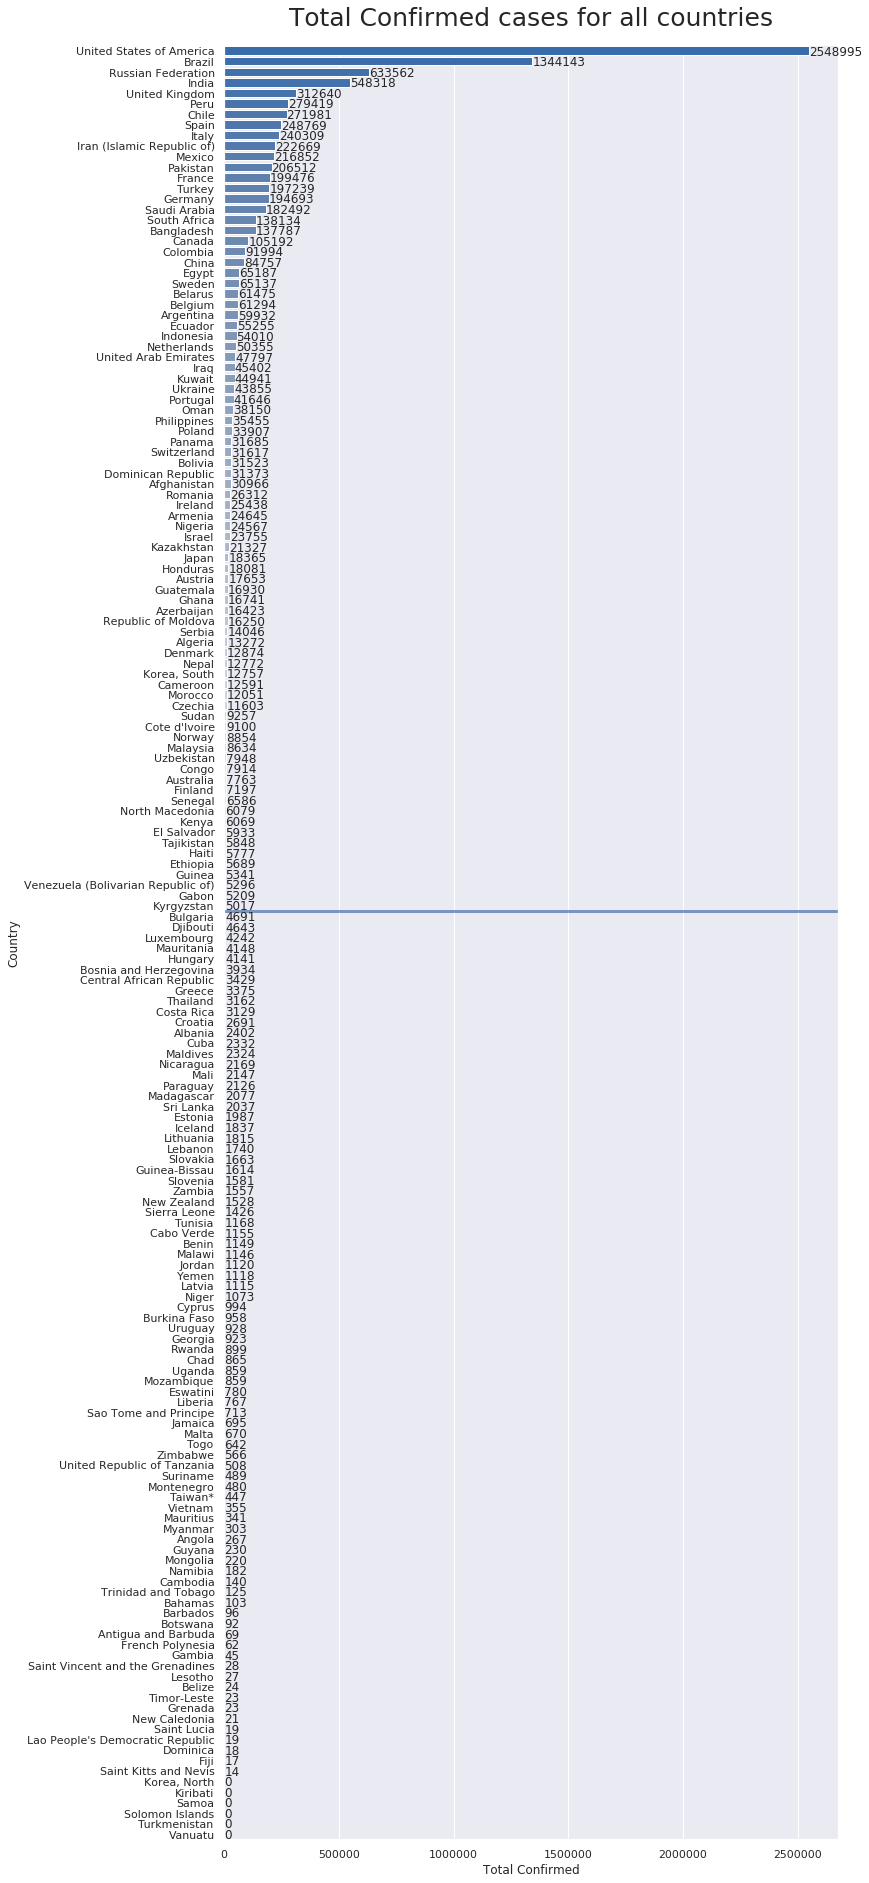

In [11]:
# Plot 'Total Confirmed' for all countries before applying the threshold, and specify the threshold location
plot_countries_threshold(df_fat_original, 33, 0, "vlag", "Total Confirmed", True, 81.5, "Total Confirmed cases for all countries")



### Plot 'Total Confirmed' cases for all countries arranged descendingly, after applying threshold of larger than 5000

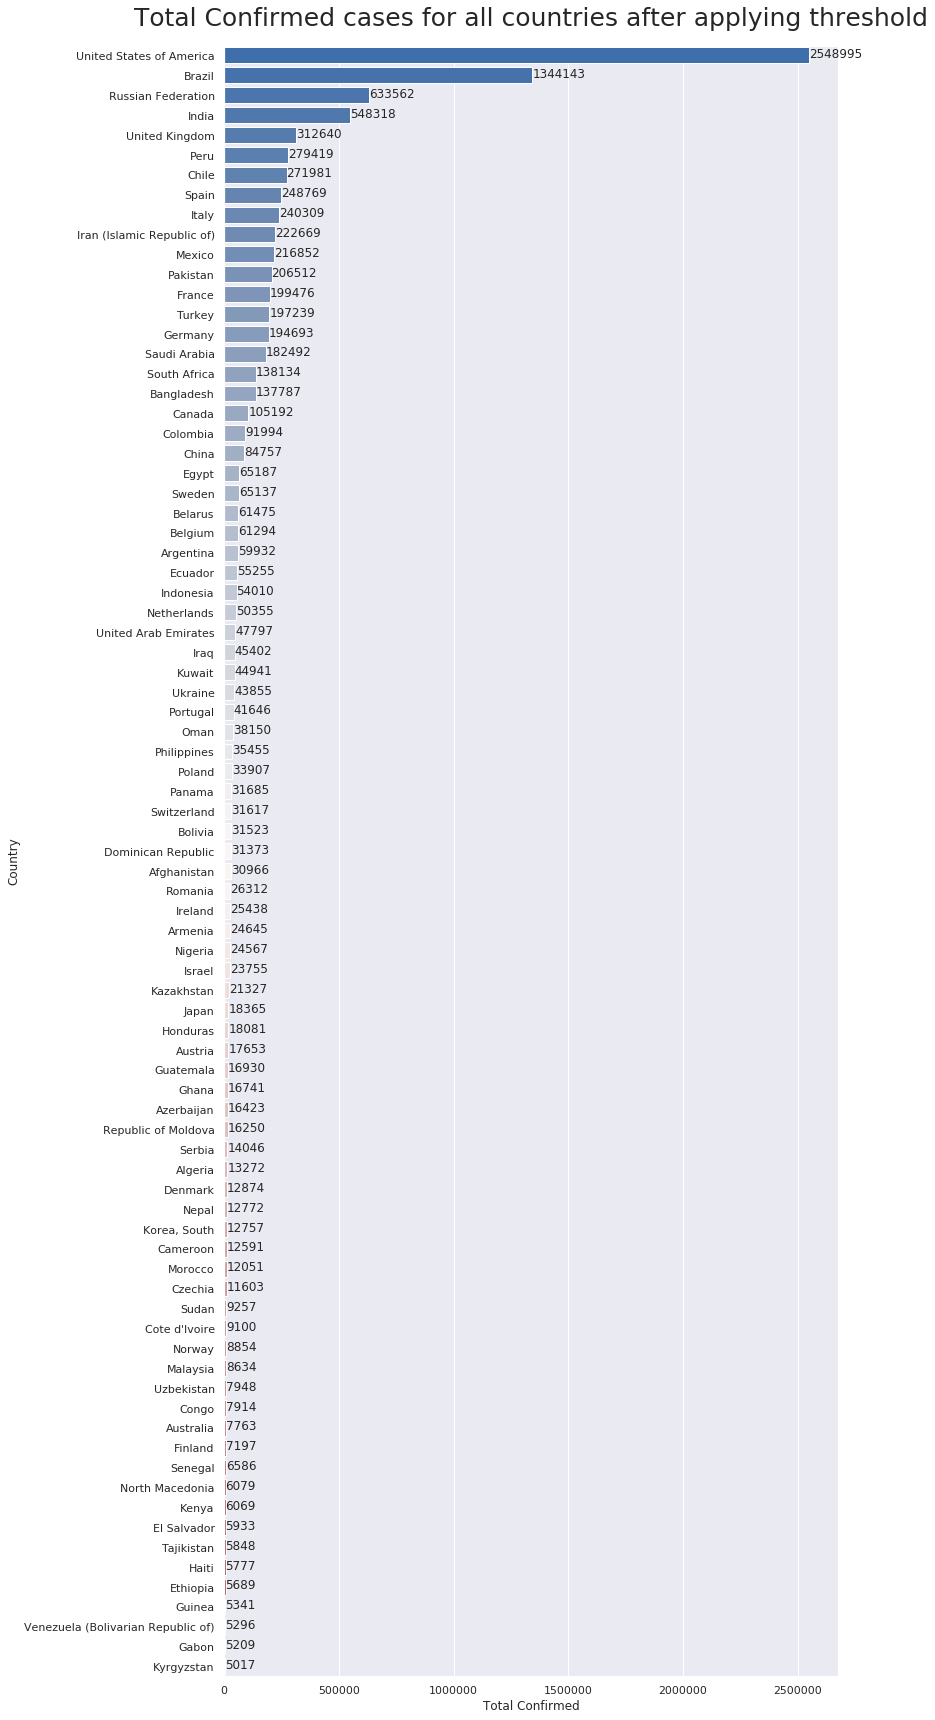

In [12]:
# Plot 'Total Confirmed' for all countries after applying the threshold
plot_countries_threshold(df_fat, 30, -0.3, "vlag", "Total Confirmed", False, 0, "Total Confirmed cases for all countries after applying threshold")


### Plot 'Total Confirmed' cases for only top and lower 10 countries before applying the threshold, with drawing a line between them

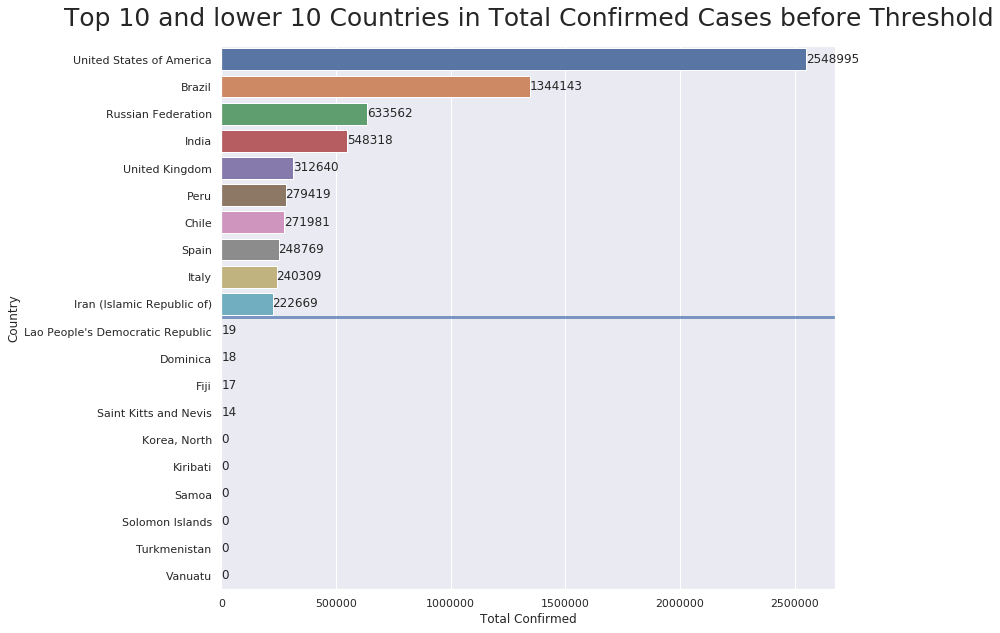

In [13]:
# Plot 'Total Confirmed' for top and bottom 10 countries before applying the threshold
df_fat_original_top_10 = df_fat_original.sort_values(by=['Total Confirmed'], ascending=False).head(10)

df_fat_original_tail_10 = df_fat_original.sort_values(by=['Total Confirmed'], ascending=False).tail(10)

df_fat_original_10 = pd.concat([df_fat_original_top_10, df_fat_original_tail_10])
plot_countries_threshold(df_fat_original_10, 10, -0.3, "deep",  "Total Confirmed", True, 9.5, "Top 10 and lower 10 Countries in Total Confirmed Cases before Threshold")


### Plot 'Total Confirmed' cases for only top and lower 10 countries after applying the threshold, with drawing a line between them

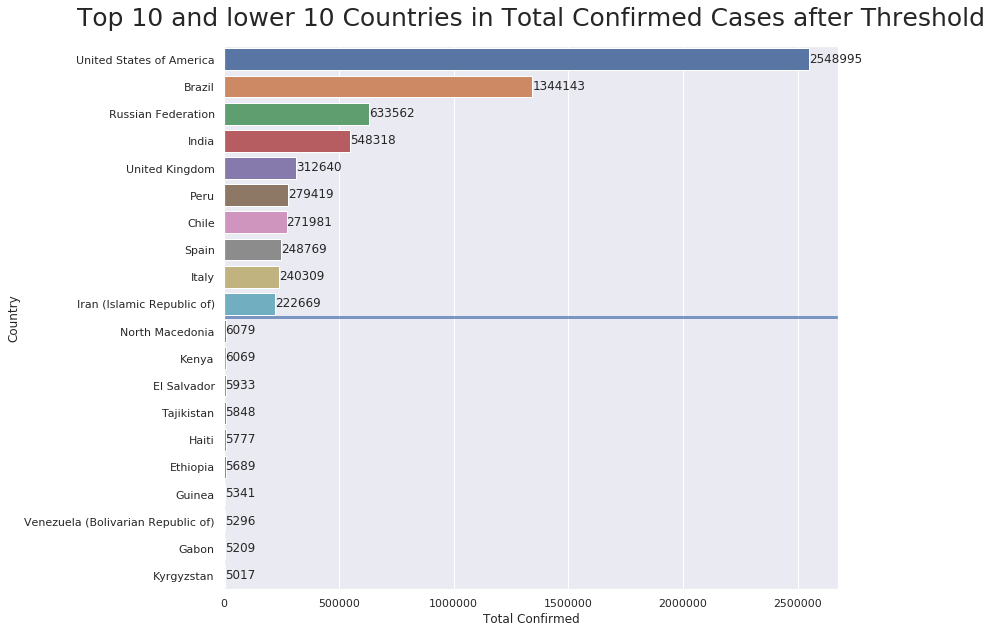

In [14]:
# Plot 'Total Confirmed' for top and bottom 10 countries after applying the threshold
df_fat_top_10 = df_fat.sort_values(by=['Total Confirmed'], ascending=False).head(10)

df_fat_tail_10 = df_fat.sort_values(by=['Total Confirmed'], ascending=False).tail(10)

df_fat_10 = pd.concat([df_fat_top_10, df_fat_tail_10])
plot_countries_threshold(df_fat_10, 10, -0.3, "deep",  "Total Confirmed", True, 9.5, "Top 10 and lower 10 Countries in Total Confirmed Cases after Threshold")


In [15]:
import random
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.tree import DecisionTreeRegressor    # Import decision tree regression model

from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from six import StringIO  

from sklearn.inspection import permutation_importance



import seaborn as sns


random.seed(42)
%matplotlib inline

## Features Importance

### Main motivation is to conduct modeling of the data, in order to put hands-on the important features regarding predicting "Recovery Rate"

#### There are different techniques used to detect these features, but in this analysis, permutation feature importance is implemented which works as follows:-

- Iterate each feature.
- Perform random shuffling of the values of that feature.
- Observe the model performance by comparing the RMSE of the model before permutating that feature _(e^orig)_, and the RMSE of the model after permutating it _(e^perm)_ by calculating this formula for each feature _(j)_ as follows:-.

$${FI}^{j} = {e}^{perm} - {e}^{orig}$$

- Then sort the features in descending order according to _(FI)_
- Only features that results in numbers > 0 are considered important.

#### This approach is used instead of default feature importance because of the following:-
- Default feature importance works by calculating mean decrease in impurity cased by each feature, then rank them descendingly.
- This isn't reliable especially when features are highly correlated.
- An example is demonstrated on the famous "Titanic Dataset", which shows that default feature importance results in "ID" to be the most important feature regarding predicting whether the corresponding passenger will survive or not, which in reality this shouldn't be the case.
- Permutation feature importance demonstrated better selection of feature regarding the same problem.


In [16]:
def plot_feature_importance(df, importance):
    
    importance_formatted = [ '%.5f' % elem for elem in importance ]
    importance_formatted = [ elem*-1 for elem in importance ]
    
    sns.set(style="ticks", color_codes=True) 

    sns.set(font_scale=1)
    
    X = df.loc[:, "Alcoholic Beverages" : "Vegetables"]

    dt_feature_names = list(X.columns)

    dt_feature_names = [w.replace('&', 'and') for w in dt_feature_names]
    
    
    dt_feature_names_sorted = [x for _,x in sorted(zip(importance_formatted,dt_feature_names))]
    
    importance_formatted.sort(reverse=True)
    
    dt_feature_names_sorted.reverse()
    

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 10))

    ax = sns.barplot(importance_formatted, y=dt_feature_names_sorted,
                     palette="deep")


    ax.set_title("Permutation Feature Importance", pad=20, fontsize= 25)


    def _show_on_single_plot(ax):
        for p in ax.patches:
                        _x = p.get_x() + p.get_width() + float(0.05)
                        _y = p.get_y() + p.get_height() + float(-0.3)
                        value = float('%.5f' % p.get_width())
                        ax.text(_x, _y, value, ha="left")

    if isinstance(ax, np.ndarray):
        for idx, ax in np.ndenumerate(ax):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(ax)
    

## Modeling 

### What to Model!

We want to investigate the different food categories consumption rates and their signifi-cance regarding COVID-19 recovery rates.  Task here is a regression problem where inputis all food categories percentages, and the output is the recovery rare.  Thus why the loss function is Root mean square error.  Main motivation behind choosing this type of modeling is that we can detect the important features ”food categories” regarding predicting recovery rate using feature importance techniques. We splitted the data into train and test datasets.

### Models

We choose multiple variants of the Decision trees family for each dataset to try to predict the Recovery rate. We then bench-marked the results for all models  and choose the best model for each given dataset. The models we choose were:

* Decision Tree.
* Random Forest. 
* Gradient Boosting. 
* Ada-boost with Decision Trees.

We choose the Decision Tree models family because it suits our size of the data the best. Another important factor was the running time considering we had to run a lot of experiments for the four models and for each of the four datasets.

### Hyper parameter tuning

To choose the best Hyper-parameters for any given model we used both Random and Grid Search. At first we use random search to narrow the search region, then we forward that region to Grid Search to return the best combination of Hyper-parameters. This procedure helped us by decreasing the training time and reduced the test error as well. 

## Decision Tree

In [ ]:
def decision_tree(df):

    X = df.loc[:, "Alcoholic Beverages":"Vegetables"]
    y = df["Rec_Rate"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=100
    )

    # Grid Search in order to find the best parameters for decision tree
    tree = DecisionTreeRegressor(criterion="mse", random_state=42)

    parameters = {
        "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    }
    gridforest = GridSearchCV(tree, parameters, cv=5, n_jobs=-1, verbose=0)
    gridforest.fit(X_train, y_train)

    # Decision Tree Training
    model = DecisionTreeRegressor(
        criterion="mse",
        max_depth=gridforest.best_params_["max_depth"],
        random_state=42,
        min_samples_leaf=gridforest.best_params_["min_samples_leaf"],
    )
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Getting Permuatation Feature Importance
    results = permutation_importance(
        model, X_test, y_test, scoring="neg_root_mean_squared_error"
    )

    importance = results.importances_mean

    # printing results
    print("********* " + "Decision Tree" + " ********* ")
    print(
        "********* " + "RMSE on Training data:",
        round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2),
        " *********",
    )
    print(
        "********* " + "RMSE on Test Set:",
        round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2),
        " *********",
    )

    dt_feature_names = list(X.columns)

    dt_feature_names = [w.replace("&", "and") for w in dt_feature_names]

    # print the tree
    dot_data = StringIO()
    export_graphviz(
        model,
        out_file=dot_data,
        filled=True,
        rounded=True,
        feature_names=dt_feature_names,
        special_characters=True,
    )
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    return (
        model,
        Image(graph.create_png()),
        round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2),
        importance,
    )


## Random Forest

In [29]:
def decision_tree(df):

    X = df.loc[:, "Alcoholic Beverages":"Vegetables"]
    y = df["Rec_Rate"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=100
    )

    # Grid Search in order to find the best parameters for decision tree
    tree = DecisionTreeRegressor(criterion="mse", random_state=42)

    parameters = {
        "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    }
    gridforest = GridSearchCV(tree, parameters, cv=5, n_jobs=-1, verbose=0)
    gridforest.fit(X_train, y_train)

    # Decision Tree Training
    model = DecisionTreeRegressor(
        criterion="mse",
        max_depth=gridforest.best_params_["max_depth"],
        random_state=42,
        min_samples_leaf=gridforest.best_params_["min_samples_leaf"],
    )
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Getting Permuatation Feature Importance
    results = permutation_importance(
        model, X_test, y_test, scoring="neg_root_mean_squared_error"
    )

    importance = results.importances_mean

    # printing results
    print("********* " + "Decision Tree" + " ********* ")
    print(
        "********* " + "RMSE on Training data:",
        round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2),
        " *********",
    )
    print(
        "********* " + "RMSE on Test Set:",
        round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2),
        " *********",
    )

    dt_feature_names = list(X.columns)

    dt_feature_names = [w.replace("&", "and") for w in dt_feature_names]

    # print the tree
    dot_data = StringIO()
    export_graphviz(
        model,
        out_file=dot_data,
        filled=True,
        rounded=True,
        feature_names=dt_feature_names,
        special_characters=True,
    )
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    return (
        model,
        Image(graph.create_png()),
        round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2),
        importance,
    )


## Adaboost

In [19]:
def adaboost(df, tree):

    X = df.loc[:, "Alcoholic Beverages":"Vegetables"]
    y = df["Rec_Rate"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=100
    )

    # Random Search for best Hyperparameters
    ada_regressor = AdaBoostRegressor(tree)

    random_search = {
        "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
        "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],
        "loss": ["linear", "sqaure", "exponential"],
    }
    ada = AdaBoostRegressor()
    rf_random = RandomizedSearchCV(
        estimator=ada,
        param_distributions=random_search,
        n_iter=100,
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs=-1,
    )
    rf_random.fit(X_train, y_train)

    best_params = rf_random.best_params_

    # Grid Search in order to find the best parameters
    parameters = {
        "n_estimators": [
            *range(
                int(best_params["n_estimators"] * 0.5),
                best_params["n_estimators"] * 2,
                50,
            )
        ],
        "learning_rate": np.linspace(
            best_params["learning_rate"] / 10, best_params["learning_rate"] * 10, 5
        ),
        "loss": ["linear", "sqaure", "exponential"],
    }

    gridforest = GridSearchCV(ada_regressor, parameters, cv=5, n_jobs=-1, verbose=0)
    gridforest.fit(X_train, y_train)

    # Adaboost Training
    ada_regressor = AdaBoostRegressor(
        tree,
        n_estimators=gridforest.best_params_["n_estimators"],
        learning_rate=gridforest.best_params_["learning_rate"],
        loss=gridforest.best_params_["loss"],
    )

    ada_regressor.fit(X_train, y_train)

    y_train_pred = ada_regressor.predict(X_train)
    y_test_pred = ada_regressor.predict(X_test)

    # Getting Permuatation Feature Importance
    results = permutation_importance(
        ada_regressor, X_test, y_test, scoring="neg_root_mean_squared_error"
    )
    importance = results.importances_mean

    # Printing Results
    print("********* " + "Adaboost" + " ********* ")
    print(
        "********* " + "RMSE on Training data:",
        round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2),
        " *********",
    )
    print(
        "********* " + "RMSE on Test Set:",
        round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2),
        " *********",
    )

    return round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2), importance


## Gradient Boost

In [23]:
def gradboost(df):
    
    X = df.loc[:, "Alcoholic Beverages":"Vegetables"]
    y = df["Rec_Rate"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=100
    )

    # Random Search for best Hyperparameters
    random_grid = {
        "max_depth": [5, 6, 7, 8, 9, 10],
        "learning_rate": [0.001, 0.01, 0.1, 1],
        "min_samples_leaf": [1, 2, 3, 4, 5],
        "loss": ["ls", "lad", "huber", "quantile"],
        "n_estimators": [100, 200, 300, 400, 500],
        "min_samples_split": [2, 4, 5, 6, 7],
    }

    gb = GradientBoostingRegressor()
    gb_random = RandomizedSearchCV(
        estimator=gb,
        param_distributions=random_grid,
        n_iter=100,
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs=-1,
    )
    gb_random.fit(X_train, y_train)

    best_params = gb_random.best_params_

    # Grid Search in order to find the best parameters
    parameters = {
        "max_depth": [
            *range(best_params["max_depth"] - 3, best_params["max_depth"] * 2, 2)
        ],
        "learning_rate": np.linspace(
            best_params["learning_rate"] / 10, best_params["learning_rate"] * 10, 5
        ),
        "n_estimators": [
            *range(
                int(best_params["n_estimators"] * 0.5),
                best_params["n_estimators"] * 2,
                50,
            )
        ],
        "min_samples_leaf": [
            *range(
                max(best_params["min_samples_leaf"] - 3, 0),
                best_params["min_samples_leaf"] * 2,
                2,
            )
        ],
        "min_samples_split": [
            *range(
                max(best_params["min_samples_split"] - 3, 0),
                best_params["min_samples_split"] * 2,
                2,
            )
        ],
        "loss": ["ls", "lad", "huber", "quantile"],
    }

    grad_regressor = GradientBoostingRegressor()

    gridforest = GridSearchCV(grad_regressor, parameters, cv=5, n_jobs=-1, verbose=0)
    gridforest.fit(X_train, y_train)

    # Gradient Boost Training
    grad_regressor = GradientBoostingRegressor(
        learning_rate=gridforest.best_params_["learning_rate"],
        loss=gridforest.best_params_["loss"],
        max_depth=gridforest.best_params_["max_depth"],
        min_samples_leaf=gridforest.best_params_["min_samples_leaf"],
        n_estimators=gridforest.best_params_["n_estimators"],
        min_samples_split=gridforest.best_params_["min_samples_split"],
    )

    grad_regressor.fit(X_train, y_train)

    y_train_pred = grad_regressor.predict(X_train)
    y_test_pred = grad_regressor.predict(X_test)

    # Getting Permuatation Feature Importance
    results = permutation_importance(
        grad_regressor, X_test, y_test, scoring="neg_root_mean_squared_error"
    )

    importance = results.importances_mean

    # Printing Results
    print("********* " + "GradBoost" + " ********* ")
    print(
        "********* " + "RMSE on Training data:",
        round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2),
        " *********",
    )
    print(
        "********* " + "RMSE on Test Set:",
        round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2),
        " *********",
    )

    dt_feature_names = list(X.columns)

    dt_feature_names = [w.replace("&", "and") for w in dt_feature_names]

    return round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2), importance


## Benchmark to compare the results of the 4 models 
 
#### Compare the test error of all the models, then plot the permutation feature importance of the model that result in the lowest test error

In [42]:
def best_ml_appraoch(df):
    """
    get the output of:
    * Decision Tree
    * Adaboost
    * Random Forest
    * Gradient Boost
    """
    d_tree, graph, mse_dt, importance_dt = decision_tree(df)
    mse_ada, importance_ada = adaboost(df, d_tree)
    mse_rf, importance_rf = random_forest(df)
    mse_gb, importance_gb = gradboost(df)
    trees = {
        mse_dt: (graph, importance_dt),
        mse_ada: (importance_ada, "Adaboost"),
        mse_rf: (importance_rf, "Random Forest"),
        mse_gb: (importance_gb, "Gradient Boosting"),
    }
    min_mse = min(trees.keys())
    if min_mse is mse_dt:

        print(
            "*********************** Decision Tree is the best Algorithm ***********************"
        )
        graph, importance = trees[min_mse]
        plot_feature_importance(df, importance)

    else:
        importance, algorithm = trees[min_mse]
        print(
            f"*********************** {algorithm} is the best Algorithm ***********************"
        )
        plot_feature_importance(df, importance)


## Protein Supply Quantity Dataset Results

********* Decision Tree ********* 
********* RMSE on Training data: 14.33  *********
********* RMSE on Test Set: 14.35  *********
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 out of 300 | elapsed:    1.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.0s finished


********* Adaboost ********* 
********* RMSE on Training data: 5.31  *********
********* RMSE on Test Set: 8.91  *********
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 260 out of 300 | elapsed:    2.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.3s finished


********* Random Forest ********* 
********* RMSE on Training data: 18.73  *********
********* RMSE on Test Set: 8.13  *********
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 out of 300 | elapsed:    0.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.9s finished


********* GradBoost ********* 
********* RMSE on Training data: 17.27  *********
********* RMSE on Test Set: 5.14  *********
*********************** Gradient Boosting is the best Algorithm ***********************


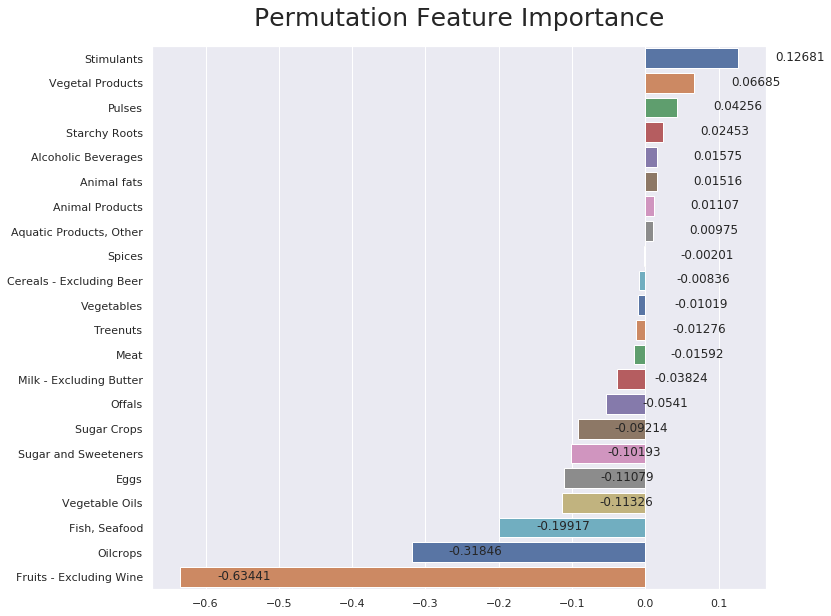

In [19]:
best_ml_appraoch(df_protein)

## Fat Supply Quantity Dataset Results

********* Decision Tree ********* 
********* RMSE on Training data: 15.13  *********
********* RMSE on Test Set: 13.51  *********
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 out of 300 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.2s finished


********* Adaboost ********* 
********* RMSE on Training data: 3.41  *********
********* RMSE on Test Set: 15.84  *********
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 out of 300 | elapsed:    1.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done 260 out of 300 | elapsed:    2.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.5s finished


********* Random Forest ********* 
********* RMSE on Training data: 16.04  *********
********* RMSE on Test Set: 8.98  *********
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 out of 300 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 260 out of 300 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.4s finished


********* GradBoost ********* 
********* RMSE on Training data: 2.62  *********
********* RMSE on Test Set: 16.96  *********
*********************** Random Forest is the best Algorithm ***********************


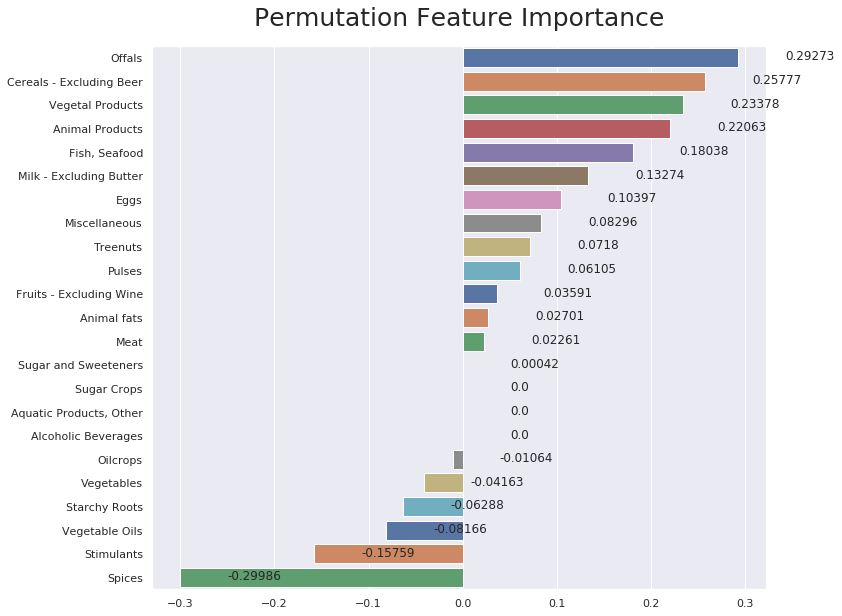

In [30]:
best_ml_appraoch(df_fat)

## Food Supply Quantity in Kcal Dataset Results

********* Decision Tree ********* 
********* RMSE on Training data: 17.44  *********
********* RMSE on Test Set: 14.35  *********
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 out of 300 | elapsed:    1.2s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done 260 out of 300 | elapsed:    4.9s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.9s finished


********* Adaboost ********* 
********* RMSE on Training data: 17.31  *********
********* RMSE on Test Set: 8.91  *********
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 out of 300 | elapsed:    1.4s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done 260 out of 300 | elapsed:    3.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.9s finished


********* Random Forest ********* 
********* RMSE on Training data: 17.73  *********
********* RMSE on Test Set: 8.75  *********
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 out of 300 | elapsed:    0.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done 260 out of 300 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.9s finished


********* GradBoost ********* 
********* RMSE on Training data: 15.4  *********
********* RMSE on Test Set: 5.43  *********
*********************** Gradient Boosting is the best Algorithm ***********************


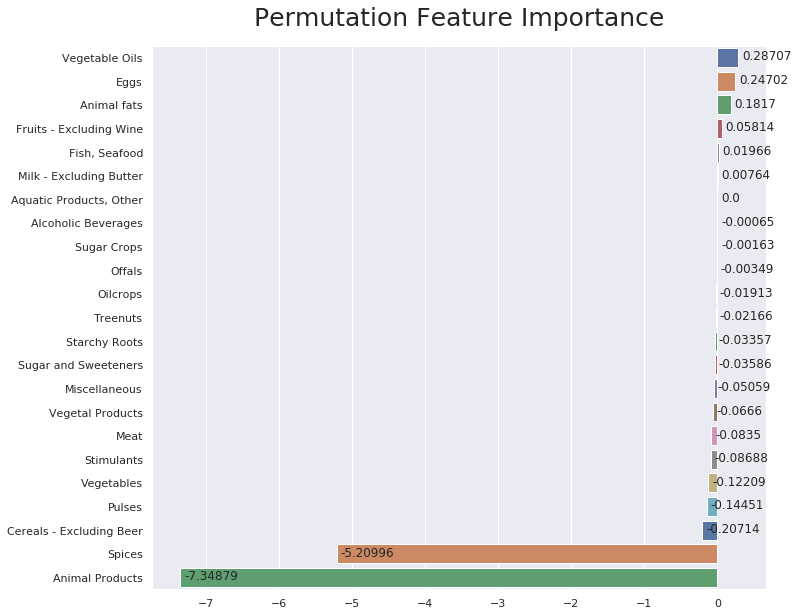

In [22]:
best_ml_appraoch(df_kcal)

## Food Supply Quantity in Kg Dataset Results

********* Decision Tree ********* 
********* RMSE on Training data: 16.02  *********
********* RMSE on Test Set: 5.76  *********
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 out of 300 | elapsed:    1.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done 260 out of 300 | elapsed:    5.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.8s finished


********* Adaboost ********* 
********* RMSE on Training data: 14.27  *********
********* RMSE on Test Set: 6.9  *********
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 out of 300 | elapsed:    1.4s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done 260 out of 300 | elapsed:    3.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.6s finished


********* Random Forest ********* 
********* RMSE on Training data: 17.56  *********
********* RMSE on Test Set: 8.01  *********
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 out of 300 | elapsed:    0.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done 260 out of 300 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    4.0s finished


********* GradBoost ********* 
********* RMSE on Training data: 5.23  *********
********* RMSE on Test Set: 5.23  *********
*********************** Gradient Boosting is the best Algorithm ***********************


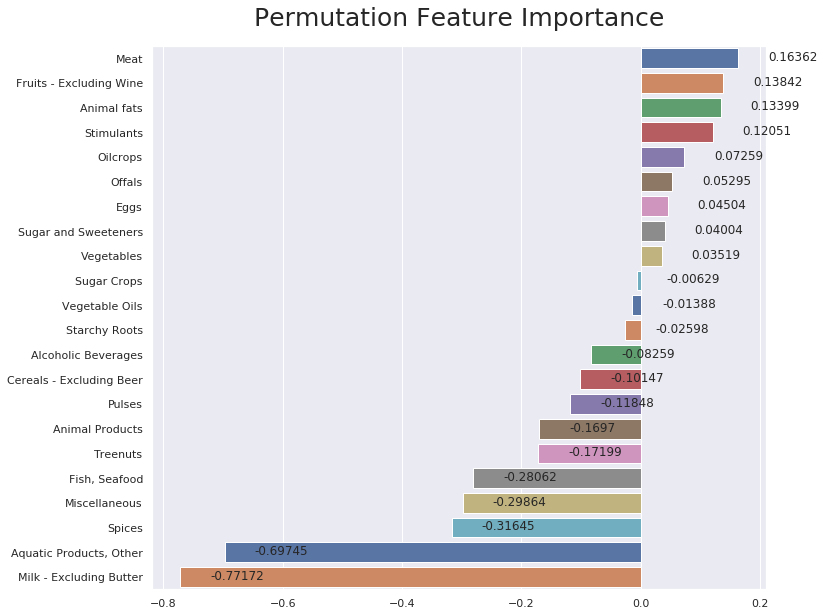

In [24]:
best_ml_appraoch(df_kg)